<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Tutorial on Generalized Linear Models (GLM) </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Wednesday, August 28, 2021</h3> 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> As scientists, we want to build models of data that are as simple as possible, and are able to explain the data as well as possible. Sometimes, when linear regression doesn't cut it and more complicated nonlinear models are too difficult to fit and/or analyze, Genaralized Linear Models (GLM) can be a good choice. They have also been used a lot to model neural responses to stimuli, as we will do in this notebook.</p>
    
<p>
The GLM is defined as follows for some input $\vec{x}_i$ and output $y_i$:
</p>
<p>
$P(y_i|\vec{x}_i;\vec{w}) = F(g^{-1}(\vec{w}\cdot\vec{x}_i))$
</p>
    
<p>
Where $g$ is called the "link function", $F(m)$ represents some probability distribution with mean $m$, and $\vec{w}$ is a vector of fitted parameters. These parameters are fitted by finding the $\vec{w}$ that maximizes $\prod_{i=1}^N P(y_i|\vec{x}_i;\vec{w})$ for some dataset of $N$ samples. Note that when $g$ is the identity, and $F$ is the normal distribution with some fixed variance, this is just a linear regression problem.
</p>
   
<p>
    To model neural spiking, $y_i$ will be the number of spikes a neuron fires in time bin $i$, and $\vec{x}_i$ will be a vector of all the predictors used to predict $y_i$. This will include three types of predictors:</p>
   

 1. The stimulus incident on our neuron during time bin $i$, and for $d-1$ time bins leading up to it
    
 2. The spiking history of our neuron for $d$ time bins leading up to time bin $i$
    
 3. A constant $1$ - the corresponding element of $\vec{w}$ will be an offset term

<p>
Each vector will therefore look like this: 
    $\vec{x}_i = [stimulus_i,...,stimulus_{i-d+1},y_{i-1},...,y_{i-d},1]^T$
</p>
   
<p>   
We refer to the corresponding parts of $\vec{w}$ as the "stimulus filter", "spike history filter", and "offset". Traditionally, for using GLMs to model neural spiking, we use a log link function, i.e. $g^{-1}(a) = e^a$, and a Poisson distribution.
</p>
   
<p>
In this tutorial, we will use the statsmodels package to fit parameters for GLMs, since it is simple and fast. However, note that doing more complicated things, like fitting GLMs with regularization, requires a more complicated solution.
</p> 
    
<p>
In order to use this package, we must supply $y_i$ and $\vec{x}_i$ for all $i$. Statsmodels expects a vector [y_1,...,y_N]^T of outputs and a "design matrix" of inputs: </p>
    
$$\begin{bmatrix} \vec{x}_i^T \\ \vdots \\ \vec{x}_N^T \end{bmatrix}$$
    
</div>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

# we will use this package to fit GLMs to data
import statsmodels.api as sm

%matplotlib inline

# tab completion in the notebook sometimes has trouble with large dataframes
# this will fix it
%config Completer.use_jedi = False

Several helper functions to take care of simulating the output of a GLM and fitting a GLM to data (including constructing the design matrix)

In [2]:
"""
Simulate a GLM's response to a 1D stimulus
Inputs:
stim: The stimulus - np array with shape (T,) 
stim_filt: Stimulus filter - np array with shape (d,)
spk_filt: Spike history filter - np array with shape (d,)
offset: Offset term - scalar
max_spikes_per_bin: Maximum number of spikes allowed in a single time bin

Outputs:
spks: the spiking response - (T,) ndarray
"""

def sim_GLM(stim, stim_filt, spk_filt, offset,max_spikes_per_bin=5):
    d = stim_filt.size
    T = stim.size
    spks = np.zeros((T,)) # starts at time step d
    rate = np.zeros((T,))
    for i in range(d,T):
        rate[i] = np.exp(np.flip(stim_filt,-1).dot(stim[i-d+1:i+1])+np.flip(spk_filt,-1).dot(spks[i-d:i])+offset)
        spks[i] = np.random.poisson(rate[i])
        spks[i] = min(spks[i],max_spikes_per_bin)
    return spks


"""
Construct the design matrix for a given stimulus and spiking response
Inputs:
flat_stimulus: the stimulus - an (MxT) ndarray, M is the dimension of the stimulus, T is the number of time samples
binned_spikes: the spiking response - a (T,) ndarray 
d: integer - how many time bins of history to use as predictors

Outputs:
y: the dependent variable to be predicted (spiking response) - (T-d,) ndarray
X_dsn: the design matrix of independent variables - 2D ndarray
"""

def construct_Xdsn(flat_stimulus, binned_spikes, d):
    T = binned_spikes.size # T is number of time bins
    sh = flat_stimulus.shape # M is the size of a stimulus
    if len(sh)==1:
        M = 1
        T1 = sh[0]
        flat_stimulus = np.expand_dims(flat_stimulus,axis=0)
    else:
        (M,T1) = sh  
    assert T==T1, "arrays have a different number of time samples"
    
    y = binned_spikes[d:]
    X_dsn = np.ones((T-d,M*d+d+1))
    for t in range(T-d):
        X_dsn[t,:M*d] = np.flip(flat_stimulus[:,t+1:t+d+1],-1).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d:-1] = np.flip(binned_spikes[t:t+d],-1).reshape((1,-1)) #spike inputs
    return y, X_dsn


"""
Fit GLM parameters for a given stimulus and spiking response
Inputs:
flat_stimulus: the stimulus - an (MxT) ndarray, M is the dimension of the stimulus, T is the number of time samples
binned_spikes: the spiking response - a (T,) ndarray 
d: integer - how many time bins of history to use as predictors

Outputs:
stim_filt, spk_filt, b: the stimulus filter, spike history filter, and offset term
stim_se, spk_se, b_se: the standard errors for these parameter estimates
"""
def fit_GLM(flat_stimulus, binned_spikes, d):
    y, Xdsn = construct_Xdsn(flat_stimulus,binned_spikes,d)
    model =  sm.GLM(y,Xdsn,family = sm.families.Poisson())
    model_results = model.fit()
    p = model_results.params
    se = model_results.bse
    
    b = p[-1]
    b_se = se[-1]
    stim_filt = p[:-1-d]
    if stim_filt.size>d:
        stim_filt = stim_filt.reshape([-1,d])
    stim_se = se[:-1-d]
    spk_filt = p[-1-d:-1]
    spk_se = se[-1-d:-1]
    return stim_filt, spk_filt, b, stim_se, spk_se, b_se

Now let's play around with simulating a GLM with some hand-picked parameters

(-20.0, 2.0)

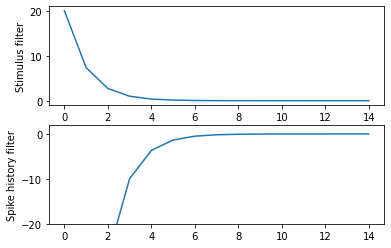

In [3]:
d = 15
t_f = np.arange(d)
spk_filt = -200*np.exp(-t_f/1.0)
stim_filt = 20*np.exp(-t_f/1.0)
b = -15.5

plt.subplot(2,1,1)
plt.plot(stim_filt,label='true')
plt.ylabel('Stimulus filter')
plt.subplot(2,1,2)
plt.plot(spk_filt,label='true')
plt.ylabel('Spike history filter')
plt.ylim([-20,2])

Let's simulate a random Gaussian stimulus to feed into our GLM, and simulate the spiking response

Text(0.5, 0, 'time (samples)')

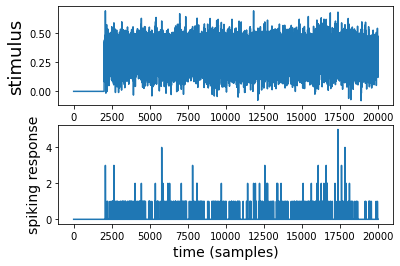

In [4]:
T = 20000
stim = np.random.normal(loc=0.3, scale=0.1,size=(T,))
# stim = (1+np.sin(np.arange(T)/200))*0.2
stim[0:T//10] = 0
spks = sim_GLM(stim,stim_filt,spk_filt,b)

plt.subplot(2,1,1)
plt.plot(stim)
plt.ylabel('stimulus',fontsize=18)
plt.subplot(2,1,2)
plt.plot(spks)
plt.ylabel('spiking response',fontsize=14)
plt.xlabel('time (samples)',fontsize=14)

Now let's use our fit_GLM function to see how well we can recover the true parameters

true offset =  -15.5  fit offset =  -15.66661658412178  +/-  0.7580068175140482


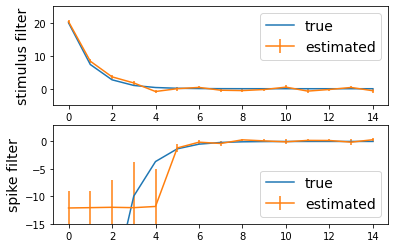

In [5]:
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se = fit_GLM(stim,spks,d)
plt.subplot(2,1,1)
plt.plot(stim_filt,label='true')
plt.errorbar(np.arange(d),stim_filt_fit,yerr=stim_se,label='estimated')
plt.legend(fontsize=14)
plt.ylabel('stimulus filter',fontsize=14)
plt.ylim(-5,25)

plt.subplot(2,1,2)
plt.plot(spk_filt,label='true')
plt.errorbar(np.arange(d),spk_filt_fit,yerr=spk_se,label='estimated')
plt.legend(fontsize=14)
plt.ylabel('spike filter',fontsize=14)
plt.ylim([-15,3])

print('true offset = ', b, ' fit offset = ', b_fit, ' +/- ', b_se)


Now let's practice fitting a GLM to Neuropixels data

In [6]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"
    data_root = "/run/media/tom.chartrand/Brain2019"

# manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

In [7]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session

# cache = EcephysProjectCache.fixed(manifest=manifest_path)

In [8]:
### for now downloading
manifest_path = os.path.join('/Users/danielzdeblick/ecephys_cache_dir/', "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


In [9]:
session_id=750749662
session = cache.get_session_data(session_id)

For now, let's stick with a simple stimulus, flashes

In [10]:
stim_table = session.get_stimulus_table('flashes')

In [11]:
len(stim_table)

150

In [12]:
stim_table.head()

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1285.319199,1.0,flashes,1285.569407,0.250208,244
3648,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1287.320839,1.0,flashes,1287.571055,0.250216,244
3649,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1289.322569,1.0,flashes,1289.572772,0.250203,245
3650,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1291.324229,1.0,flashes,1291.574432,0.250203,245
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1293.325909,1.0,flashes,1293.576112,0.250203,245


We need to make a choice about how represent the stimulus during each time bin as a vector. for now, we'll choose 10ms bins with a scalar value:
 - +1 if a bright flash takes up most of the bin
 - -1 if a dark flash takes up most of the bin
 - 0 otherwise

In [13]:
flashes = 150
start = np.round(stim_table.start_time.iloc[0]-0.3,decimals=2)
stop = np.round(stim_table.stop_time.iloc[flashes-1]+0.3,decimals=2)
dt = 0.01
T = int((stop-start)/dt)
print(start,stop,T)

1285.02 1584.12 29909


Text(0, 0.5, 'stimulus')

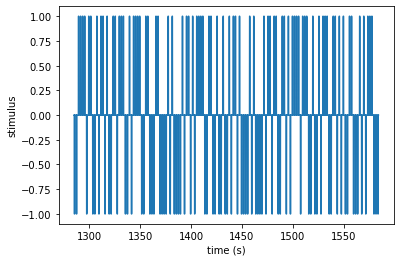

In [14]:
time_vector = np.arange(T)*dt+start
stim_vector = np.zeros((T,))
for flash in range(flashes):
    start_bin = int(np.round((stim_table.start_time.iloc[flash]-start)/dt))
    stop_bin = int(np.round((stim_table.stop_time.iloc[flash]-start)/dt))
    stim_vector[start_bin:stop_bin] = stim_table.color.iloc[flash]
plt.plot(time_vector,stim_vector)
plt.xlabel('time (s)')
plt.ylabel('stimulus')

Now let's pick a single neuron and count how many times it spikes in each of these bins

In [15]:
unit_id = session.units[session.units.ecephys_structure_acronym=='VISp'].index[2] #2,6,12,17
# print(unit_id)

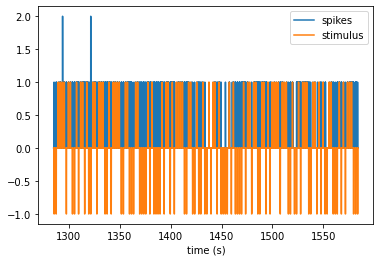

In [16]:
spk_vector = np.zeros_like(stim_vector)
for spike_time in session.spike_times[unit_id]:
    if (spike_time>start) and (spike_time<stop):
        spk_bin = int((spike_time-start)/dt)
        spk_vector[spk_bin] += 1   

plt.xlabel('time (s)')
plt.plot(time_vector,spk_vector,label='spikes')
plt.plot(time_vector,stim_vector,label='stimulus')
plt.legend()


Now let's fit a GLM to this data and see what the parameters look like

estimated offset =  -4.531973990321231  +/-  0.0594884754678959


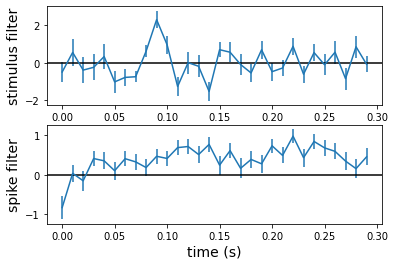

In [17]:
d = 30 #30*10ms = 300ms, longer than a flash
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se = fit_GLM(stim_vector,spk_vector,d)
plt.subplot(2,1,1)
plt.errorbar(np.arange(d)*dt,stim_filt_fit,yerr=stim_se,label='estimated')
plt.axhline(c='k')
# plt.xlabel('time (s)',fontsize=14)
plt.ylabel('stimulus filter',fontsize=14)
# plt.ylim(-5,25)

plt.subplot(2,1,2)
plt.errorbar(np.arange(d)*dt,spk_filt_fit,yerr=spk_se,label='estimated')
plt.axhline(c='k')
plt.ylabel('spike filter',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
# plt.ylim([-15,3])

print('estimated offset = ', b_fit, ' +/- ', b_se)